# Correlations between transcriptome and OTU microbiome data

Notebook to run correlations between the host transcriptome data and OTUs from Dr. Wallace [manuscript](https://apsjournals.apsnet.org/doi/full/10.1094/PBIOMES-02-18-0008-R).

## Datasets

### RNAseq data

Matrix with TPM values from quantifying (Salmon) with cleaned reads against the maize transcriptome (representative transcripts of maize version 5)

### 16S data

The matrix that will be used corresponds to the OTU table generated by Dr. Wallace, which is in the FigShare repository lited in [Wallace et al. (2018)](https://apsjournals.apsnet.org/doi/full/10.1094/PBIOMES-02-18-0008-R).

In [33]:
kremling_expression_key = '/home/rsantos/Repositories/maize_microbiome_transcriptomics/correlations_rnaseq_metataxonomics/0_kremling_expression_key.txt'
sra_run_table_16s = '/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/SraRunInfo_Wallace_etal_2018.csv'
sra_run_table_rnaseq = '/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/run_info/SraRunInfo_Kremling_etal_2018.csv'

dict_wallace_kremling_2018 = {}
kremling_expression_key_dict = {}

In [34]:
with open(kremling_expression_key, 'r') as file:

    _ = file.readline()

    for line in file:
        fields = line.strip().split('\t')
        
        kremling_identifier = fields[0]
        wallace_identifier = fields[1]

        # Adding both identifiers (Wallace and Kremling) to the dictionary
        kremling_expression_key_dict[kremling_identifier] = wallace_identifier
        kremling_expression_key_dict[wallace_identifier] = kremling_identifier

In [36]:
import re

with open(sra_run_table_rnaseq, 'r') as file:

    _ = file.readline()

    for line in file:
        fields = line.strip().split(',')
        fields2 = fields[11].split('_')
        rnaseq_run_id = fields[0]
        sample_id = fields2[1]
        rnaseq_genotype = fields2[2]
        day = ''
        match = re.search(r'\d+', sample_id)
        unmatched_parts = re.split(r'\d+', sample_id)
        day_period = unmatched_parts[0]
        if match:
            day = int(match.group())
        if sample_id.startswith('LMA') and rnaseq_genotype != '#N/A':
            dict_wallace_kremling_2018[fields[11]] = {'run_accession_16s': '',
                                    'run_accession_rnaseq': rnaseq_run_id,
                                    'day': day,
                                    'day_period': day_period,
                                    'genotype_16s': '',
                                    'genotype_rnaseq': rnaseq_genotype}

In [37]:
rnaseq_samples_with_16s = 0

with open(sra_run_table_16s, 'r') as file:

    _ = file.readline()

    for line in file:
        fields = line.strip().split(',')
        fields2 = fields[11].split('.')
        metataxonomics_run_id = fields[0]
        day = int(fields2[1])
        day_period = fields2[0]
        for key, value in kremling_expression_key_dict.items():
            if value == fields[11]:
                if dict_wallace_kremling_2018[key]['day'] != day:
                    print('Big problem!')
                    print(day, dict_wallace_kremling_2018[key]['day'])
                    print(dict_wallace_kremling_2018[key])
                    print(value, fields[11], key)
                    exit(1)
                if dict_wallace_kremling_2018[key]['day_period'] != day_period:
                    print('Big problem!')
                    if key == '10343927_LMAN8_CML505_CAACAG':
                        print("It's ok. I know this sample is problematic.")
                        continue
                    else:
                        print(day_period, dict_wallace_kremling_2018[key]['day_period'])
                        print(dict_wallace_kremling_2018[key])
                        print(value, fields[11], key)
                        exit(1)
                dict_wallace_kremling_2018[key]['run_accession_16s'] = metataxonomics_run_id
                rnaseq_samples_with_16s+=1

print(f'{rnaseq_samples_with_16s} sample pairs found.')

Big problem!
It's ok. I know this sample is problematic.
484 sample pairs found.


In [38]:
no_16s = 0
for key, value in dict_wallace_kremling_2018.items():
    if value['run_accession_16s'] == '':
        print(key, value)
        no_16s+=1
print(f'{no_16s} samples without 16S data.')

10343927_LMAN8_B73_CACACT {'run_accession_16s': '', 'run_accession_rnaseq': 'SRR5909633', 'day': 8, 'day_period': 'LMAN', 'genotype_16s': '', 'genotype_rnaseq': 'B73'}
10343927_LMAN8_CML505_CAACAG {'run_accession_16s': '', 'run_accession_rnaseq': 'SRR5911345', 'day': 8, 'day_period': 'LMAN', 'genotype_16s': '', 'genotype_rnaseq': 'CML505'}
2 samples without 16S data.


# Generating a matrix with both RNAseq and OTUs from Wallace et al (2018)

Associations between 16S and RNAseq data are present in the 'dict_wallace_kremling_2018' dictionary.

In [39]:
run2my_sample_id = {}

for key in dict_wallace_kremling_2018:
    if dict_wallace_kremling_2018[key]['run_accession_rnaseq']:
        run2my_sample_id[dict_wallace_kremling_2018[key]['run_accession_rnaseq']] = key
    if dict_wallace_kremling_2018[key]['run_accession_16s']:
        run2my_sample_id[dict_wallace_kremling_2018[key]['run_accession_16s']] = key

In [40]:
import pandas as pd

# Importing expression data from Kremling et al. 2018 (TPM matrix on Maize v5 using Salmon after cleaning with cutadapt)
kremling_expression_v5 = pd.read_csv('/media/rsantos/4TB_drive/Projects/UGA_RACS/RNAseq/Salmon/Zma2_tpm_matrix.txt', sep='\t')

# Rename column and reset the index
kremling_expression_v5.set_index('Name', inplace=True)

# Print the dataframe
kremling_expression_v5.head()

,SRR5909626,SRR5909627,SRR5909633,SRR5909635,SRR5909639,SRR5909642,SRR5909645,SRR5909653,SRR5909655,SRR5909665,...,SRR5912073,SRR5912081,SRR5912082,SRR5912083,SRR5912093,SRR5912094,SRR5912104,SRR5912105,SRR5912111,SRR5912116
Name,,,,,,,,,,,,,,,,,,,,,
Zm00001eb371370_T002,1.04145,0.0000,3.391060,0.0,0.0000,1.82712,0.284514,2.23201,0.437147,0.468934,...,0.00000,1.51042,0.00000,0.0,0.00000,2.82055,3.96967,0.00000,2.96105,0.00000
Zm00001eb371350_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371330_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371310_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371280_T001,1.27650,2.1092,0.692731,0.0,4.2798,1.47496,2.557320,0.00000,1.065940,1.149530,...,3.02253,0.41140,1.17447,0.0,3.48749,9.47506,6.19189,3.80776,1.03695,1.14981


#### Renaming columns

Renaming columns of Kremling data based on associations in 'run2my_sample_id'based'

In [41]:
# Rename the columns using the dictionary
kremling_expression_v5 = kremling_expression_v5.rename(columns=run2my_sample_id)
kremling_expression_v5.columns = [str(x) for x in kremling_expression_v5.columns]

kremling_expression_v5.head()

,10343927_LMAD26_CI21E_AAGTGG,10343264_LMAN26_CI21E_ATGAAC,10343927_LMAN8_B73_CACACT,10343264_LMAN26_B64_ACCAGT,10343262_LMAN8_B109_TGCTAT,10343262_LMAN8_B14A_CTCTCG,10343262_LMAN8_B57_CCTAAG,10343927_LMAD26_B77_TAATCG,10343262_LMAN8_B79_GCAGCC,10343927_LMAN8_CI187-2_GACGAT,...,10344826_LMAN8_I29_ACGTCT,10344823_LMAD8_IA2132_ACACGC,10343264_LMAD26_CML91_AACGCC,10344827_LMAN26_CML91_AATCCG,10344827_LMAN26_Ki21_AAGACA,10343927_LMAD26_Ki21_ACGTCT,10344826_LMAD8_E2558W_CGCAAC,10343927_LMAN8_E2558W_GAACCT,10344826_LMAD8_IDS69_CAGGAC,10343927_LMAN8_IDS69_ACATTA
Name,,,,,,,,,,,,,,,,,,,,,
Zm00001eb371370_T002,1.04145,0.0000,3.391060,0.0,0.0000,1.82712,0.284514,2.23201,0.437147,0.468934,...,0.00000,1.51042,0.00000,0.0,0.00000,2.82055,3.96967,0.00000,2.96105,0.00000
Zm00001eb371350_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371330_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371310_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371280_T001,1.27650,2.1092,0.692731,0.0,4.2798,1.47496,2.557320,0.00000,1.065940,1.149530,...,3.02253,0.41140,1.17447,0.0,3.48749,9.47506,6.19189,3.80776,1.03695,1.14981


#### Importing OTU data

OTU table was obtained from the FigShare repo associated with Wallace et al. (2018), with the `.biom` extension.
It was converted to a tabular file as described in the Gitlab wiki associated with this project.

In [42]:
out_table_taxonomy_df = pd.read_table('/media/rsantos/4TB_drive/Projects/UGA_RACS/16S/Workflow/2_QiimeOtus/2f_otu_table.sample_filtered.no_mitochondria_chloroplast_taxonomy.tsv',
                                      comment='#')

out_table_taxonomy_df.set_index('OTU ID', inplace=True)
out_table_taxonomy_df.head()

/tmp/ipykernel_320020/3435135935.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  out_table_taxonomy_df = pd.read_table('/media/rsantos/4TB_drive/Projects/UGA_RACS/16S/Workflow/2_QiimeOtus/2f_otu_table.sample_filtered.no_mitochondria_chloroplast_taxonomy.tsv',


,LMAN.8.14A0051,LMAN.8.14A0304,LMAD.8.14A0247,LMAN.8.14A0159,LMAD.8.14A0051,LMAD.26.14A0381,LMAD.26.14A0533,LMAD.8.14A0281,LMAD.8.14A0295,LMAN.26.14A0319,...,LMAN.8.14A0011,LMAD.26.14A0137,LMAN.26.14A0327,LMAN.8.14A0205,LMAD.8.14A0265,LMAD.26.14A0155,LMAD.26.14A0167,LMAD.26.14A0481,LMAN.26.14A0329,taxonomy
OTU ID,,,,,,,,,,,,,,,,,,,,,
4479944,1.0,2.0,1.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,k__Bacteria; p__Actinobacteria; c__MB-A2-108; ...
995900,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,8.0,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,k__Bacteria; p__Proteobacteria; c__Gammaproteo...
1124709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,k__Bacteria; p__Bacteroidetes; c__Cytophagia; ...
541139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,k__Bacteria; p__Tenericutes; c__Mollicutes; o_...
533625,1.0,36.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,k__Bacteria; p__Proteobacteria; c__Alphaproteo...


In [43]:
out_table_no_taxonomy_df = out_table_taxonomy_df.drop('taxonomy', axis=1)
out_table_no_taxonomy_df.head()

,LMAN.8.14A0051,LMAN.8.14A0304,LMAD.8.14A0247,LMAN.8.14A0159,LMAD.8.14A0051,LMAD.26.14A0381,LMAD.26.14A0533,LMAD.8.14A0281,LMAD.8.14A0295,LMAN.26.14A0319,...,LMAN.26.14A0303,LMAN.8.14A0011,LMAD.26.14A0137,LMAN.26.14A0327,LMAN.8.14A0205,LMAD.8.14A0265,LMAD.26.14A0155,LMAD.26.14A0167,LMAD.26.14A0481,LMAN.26.14A0329
OTU ID,,,,,,,,,,,,,,,,,,,,,
4479944,1.0,2.0,1.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
995900,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,8.0,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1124709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
541139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
533625,1.0,36.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Renaming columns of Wallace data based on associations in 'kremling_expression_key_dict'based'

In [49]:
# Rename the columns using the dictionary
out_table_no_taxonomy_df = out_table_no_taxonomy_df.rename(columns=kremling_expression_key_dict)
out_table_no_taxonomy_df.columns = [str(x) for x in out_table_no_taxonomy_df.columns]

In [50]:
out_table_no_taxonomy_df.head()

,10344826_LMAN8_SD44_GTAGAA,LMAN.8.14A0304,10344826_LMAD8_Va22_GCGCTG,10343262_LMAN8_Va35_TAATCG,10344823_LMAD8_SD44_GTGTAG,10343927_LMAD26_B73_TTCCGC,10343264_LMAD26_CML228_CCGCAA,LMAD.8.14A0281,10344826_LMAD8_NC358_GCAGCC,10344827_LMAN26_M37W_TTGGTA,...,10344827_LMAN26_B73_GAACCT,10344826_LMAN8_ND246_CGTCGC,10343927_LMAD26_NC250_CAGCGT,10344827_LMAN26_NC318_CGGTTA,10343262_LMAN8_NC362_TATGTC,10344826_LMAD8_NC264_AACGCC,10343927_LMAD26_B84_GCAGCC,10343927_LMAD26_NC314_CACTAA,10343264_LMAD26_NC366_TAATCG,10344827_LMAN26_Pa880_GCGCTG
OTU ID,,,,,,,,,,,,,,,,,,,,,
4479944,1.0,2.0,1.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
995900,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,8.0,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1124709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
541139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
533625,1.0,36.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Ensuring Wallace df has the same columns as Kremling df

In [51]:
kremling_expression_v5 = kremling_expression_v5.filter(items=out_table_no_taxonomy_df.columns)

In [55]:
print(kremling_expression_v5.shape)
kremling_expression_v5.head()

(39096, 444)


,10344826_LMAN8_SD44_GTAGAA,10344826_LMAD8_Va22_GCGCTG,10343262_LMAN8_Va35_TAATCG,10344823_LMAD8_SD44_GTGTAG,10343927_LMAD26_B73_TTCCGC,10343264_LMAD26_CML228_CCGCAA,10344826_LMAD8_NC358_GCAGCC,10344827_LMAN26_M37W_TTGGTA,10344827_LMAN26_NC258_CAACAG,10343262_LMAN8_Va102_CAACAG,...,10344827_LMAN26_B73_GAACCT,10344826_LMAN8_ND246_CGTCGC,10343927_LMAD26_NC250_CAGCGT,10344827_LMAN26_NC318_CGGTTA,10343262_LMAN8_NC362_TATGTC,10344826_LMAD8_NC264_AACGCC,10343927_LMAD26_B84_GCAGCC,10343927_LMAD26_NC314_CACTAA,10343264_LMAD26_NC366_TAATCG,10344827_LMAN26_Pa880_GCGCTG
Name,,,,,,,,,,,,,,,,,,,,,
Zm00001eb371370_T002,0.853088,0.543707,0.41081,0.841123,6.51739,0.893650,2.11575,0.477462,0.000000,0.0,...,0.00000,0.0,0.852852,0.000000,0.0,7.31828,1.72605,1.74131,2.074270,0.000000
Zm00001eb371350_T001,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.0,...,0.00000,0.0,0.000000,0.000000,0.0,0.00000,0.00000,0.00000,0.330825,0.000000
Zm00001eb371330_T001,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.0,...,0.00000,0.0,0.000000,0.000000,0.0,0.00000,0.00000,0.00000,0.000000,0.000000
Zm00001eb371310_T001,0.000000,0.000000,0.00000,0.000000,0.00000,0.406263,0.00000,0.000000,0.000000,0.0,...,0.00000,0.0,0.000000,0.000000,0.0,0.00000,0.00000,0.00000,0.000000,0.000000
Zm00001eb371280_T001,1.394160,1.332830,0.00000,23.711600,1.15772,0.365113,2.99848,0.000000,0.344033,0.0,...,2.23636,0.0,1.393780,0.338422,0.0,1.99084,0.00000,2.13431,12.542500,0.729545


In [53]:
out_table_no_taxonomy_df = out_table_no_taxonomy_df.filter(items=kremling_expression_v5.columns)

In [56]:
print(out_table_no_taxonomy_df.shape)
out_table_no_taxonomy_df.head()

(9057, 444)


,10344826_LMAN8_SD44_GTAGAA,10344826_LMAD8_Va22_GCGCTG,10343262_LMAN8_Va35_TAATCG,10344823_LMAD8_SD44_GTGTAG,10343927_LMAD26_B73_TTCCGC,10343264_LMAD26_CML228_CCGCAA,10344826_LMAD8_NC358_GCAGCC,10344827_LMAN26_M37W_TTGGTA,10344827_LMAN26_NC258_CAACAG,10343262_LMAN8_Va102_CAACAG,...,10344827_LMAN26_B73_GAACCT,10344826_LMAN8_ND246_CGTCGC,10343927_LMAD26_NC250_CAGCGT,10344827_LMAN26_NC318_CGGTTA,10343262_LMAN8_NC362_TATGTC,10344826_LMAD8_NC264_AACGCC,10343927_LMAD26_B84_GCAGCC,10343927_LMAD26_NC314_CACTAA,10343264_LMAD26_NC366_TAATCG,10344827_LMAN26_Pa880_GCGCTG
OTU ID,,,,,,,,,,,,,,,,,,,,,
4479944,1.0,1.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
995900,0.0,0.0,0.0,0.0,0.0,0.0,8.0,15.0,2.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1124709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
541139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
533625,1.0,0.0,0.0,0.0,2.0,0.0,0.0,12.0,2.0,56.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
if out_table_no_taxonomy_df.columns.all() == kremling_expression_v5.columns.all():
    print('Columns are equal!')

Columns are equal!


#### Filtering out OTUs and genes with many zeros

In [59]:
def count_zeros(df, threshold=0.5):
    # Count the number of zeros in each row
    # If the number of zeros is greater than the threshold, remove the row
    threshold_int = int(df.shape[1] * threshold)
    print(f'Threshold: {threshold_int} (threshold * number of columns)')
    zero_counts = df.apply(lambda row: (row == 0).sum(), axis=1)
    return df[zero_counts < threshold_int]

In [60]:
wallace_otus_zeros_filtered = count_zeros(out_table_no_taxonomy_df)
kremling_expression_v5_zeros_filtered = count_zeros(kremling_expression_v5)

Threshold: 222 (threshold * number of columns)
Threshold: 222 (threshold * number of columns)


In [61]:
print(wallace_otus_zeros_filtered.shape)
print(kremling_expression_v5_zeros_filtered.shape)

(442, 444)
(19938, 444)


#### Concatenating matrices and computing correlations for the OTUs

In [62]:
concatenated_df = pd.concat([wallace_otus_zeros_filtered, kremling_expression_v5_zeros_filtered], axis=0)

In [63]:
print(wallace_otus_zeros_filtered.shape)
print(kremling_expression_v5_zeros_filtered.shape)
print(concatenated_df.shape)

(442, 444)
(19938, 444)
(20380, 444)


In [64]:
concatenated_transposed = concatenated_df.T

I (RACS) decided to use CorALS:

In [65]:
from corals.threads import set_threads_for_external_libraries
set_threads_for_external_libraries(n_threads=1)
import numpy as np
from corals.correlation.full.default import cor_full

/home/rsantos/Repositories/maize_microbiome_transcriptomics/.venv/lib/python3.10/site-packages/corals/threads.py:48: UserWarning: This function should be called before `numpy` or similar modules are imported.
  warnings.warn("This function should be called before `numpy` or similar modules are imported.")


In [66]:
cor_values = cor_full(concatenated_transposed)
cor_values.shape

(20380, 20380)

In [70]:
highly_correlated_pairs_df = pd.DataFrame(columns=['feature1', 'feature2', 'correlation'])
correlated_pairs_file = open('correlated_pairs_otus_filter0_5_both.txt', 'w')

# Find the highly correlated pairs
for i in range(len(cor_values.columns)):
    for j in range(i+1, len(cor_values.columns)):
        if cor_values.columns[i] == cor_values.columns[j] or\
            (str(cor_values.columns[j]).startswith('Zm') and str(cor_values.columns[i]).startswith('Zm')):
            continue
        if ((abs(cor_values.iloc[i, j]) > 0.6) or\
           (abs(cor_values.iloc[i, j]) < -0.6)) and\
            (str(cor_values.columns[j]).startswith('Zm') or str(cor_values.columns[i]).startswith('Zm')):
            pair = (cor_values.columns[i], cor_values.columns[j])
            highly_correlated_pairs_df.loc[len(highly_correlated_pairs_df.index)] = [cor_values.columns[i],
                                                                                     cor_values.columns[j],
                                                                                     cor_values.iloc[i, j]]
            correlated_pairs_file.write(f'{cor_values.columns[i]}\t{cor_values.columns[j]}\t{cor_values.iloc[i, j]}\n')

correlated_pairs_file.close()

# Correlations between transcriptome and OTU microbiome merged Day and Night

Here I report correlations between the host transcriptome data and OTUs from Dr. Wallace [manuscript](https://apsjournals.apsnet.org/doi/full/10.1094/PBIOMES-02-18-0008-R). However, I (RACS) will used the OTU table after merging the Day and Night samples.

In [53]:
#kremling_expression_key = '/media/renato/SSD1TB/Repositories/maize_microbiome_transcriptomics/correlations_rnaseq_metataxonomics/0_kremling_expression_key.txt'
#sra_run_table_16s = '/media/renato/SSD1TB/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/SraRunInfo_Wallace_etal_2018.csv'
#sra_run_table_rnaseq = '/media/renato/SSD1TB/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/run_info/SraRunInfo_Kremling_etal_2018.csv'
kremling_expression_key = '/home/rsantos/Repositories/maize_microbiome_transcriptomics/correlations_rnaseq_metataxonomics/0_kremling_expression_key.txt'
sra_run_table_16s = '/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/SraRunInfo_Wallace_etal_2018.csv'
sra_run_table_rnaseq = '/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/run_info/SraRunInfo_Kremling_etal_2018.csv'

dict_wallace_kremling_2018 = {}
kremling_expression_key_dict = {}

In [54]:
with open(kremling_expression_key, 'r') as file:

    _ = file.readline()

    for line in file:
        fields = line.strip().split('\t')
        
        kremling_identifier = fields[0]
        wallace_identifier = fields[1]

        # Adding both identifiers (Wallace and Kremling) to the dictionary
        kremling_expression_key_dict[kremling_identifier] = wallace_identifier
        kremling_expression_key_dict[wallace_identifier] = kremling_identifier

In [55]:
import re

with open(sra_run_table_rnaseq, 'r') as file:

    _ = file.readline()

    for line in file:
        fields = line.strip().split(',')
        fields2 = fields[11].split('_')
        rnaseq_run_id = fields[0]
        sample_id = fields2[1]
        rnaseq_genotype = fields2[2]
        day = ''
        match = re.search(r'\d+', sample_id)
        unmatched_parts = re.split(r'\d+', sample_id)
        day_period = unmatched_parts[0]
        if match:
            day = int(match.group())
        if sample_id.startswith('LMA') and rnaseq_genotype != '#N/A':
            dict_wallace_kremling_2018[fields[11]] = {'run_accession_16s': '',
                                    'run_accession_rnaseq': rnaseq_run_id,
                                    'day': day,
                                    'day_period': day_period,
                                    'genotype_16s': '',
                                    'genotype_rnaseq': rnaseq_genotype}

In [56]:
rnaseq_samples_with_16s = 0

with open(sra_run_table_16s, 'r') as file:

    _ = file.readline()

    for line in file:
        fields = line.strip().split(',')
        fields2 = fields[11].split('.')
        metataxonomics_run_id = fields[0]
        day = int(fields2[1])
        day_period = fields2[0]
        for key, value in kremling_expression_key_dict.items():
            if value == fields[11]:
                if dict_wallace_kremling_2018[key]['day'] != day:
                    print('Big problem!')
                    print(day, dict_wallace_kremling_2018[key]['day'])
                    print(dict_wallace_kremling_2018[key])
                    print(value, fields[11], key)
                    exit(1)
                if dict_wallace_kremling_2018[key]['day_period'] != day_period:
                    print('Big problem!')
                    if key == '10343927_LMAN8_CML505_CAACAG':
                        print("It's ok. I know this sample is problematic.")
                        continue
                    else:
                        print(day_period, dict_wallace_kremling_2018[key]['day_period'])
                        print(dict_wallace_kremling_2018[key])
                        print(value, fields[11], key)
                        exit(1)
                dict_wallace_kremling_2018[key]['run_accession_16s'] = metataxonomics_run_id
                rnaseq_samples_with_16s+=1

print(f'{rnaseq_samples_with_16s} sample pairs found.')

Big problem!
It's ok. I know this sample is problematic.
484 sample pairs found.


In [57]:
no_16s = 0
for key, value in dict_wallace_kremling_2018.items():
    if value['run_accession_16s'] == '':
        print(key, value)
        no_16s+=1
print(f'{no_16s} samples without 16S data.')

10343927_LMAN8_B73_CACACT {'run_accession_16s': '', 'run_accession_rnaseq': 'SRR5909633', 'day': 8, 'day_period': 'LMAN', 'genotype_16s': '', 'genotype_rnaseq': 'B73'}
10343927_LMAN8_CML505_CAACAG {'run_accession_16s': '', 'run_accession_rnaseq': 'SRR5911345', 'day': 8, 'day_period': 'LMAN', 'genotype_16s': '', 'genotype_rnaseq': 'CML505'}
2 samples without 16S data.


In [58]:
run2my_sample_id = {}

for key in dict_wallace_kremling_2018:
    if dict_wallace_kremling_2018[key]['run_accession_rnaseq']:
        run2my_sample_id[dict_wallace_kremling_2018[key]['run_accession_rnaseq']] = key
    if dict_wallace_kremling_2018[key]['run_accession_16s']:
        run2my_sample_id[dict_wallace_kremling_2018[key]['run_accession_16s']] = key

Importing the merged OTU table:

In [59]:
import pandas as pd

#otu_table_merged_d_n = pd.read_csv('/media/renato/SSD1TB/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/summed_day_night_otu_counts.tsv',
#                                   sep='\t', index_col='OTU ID')
otu_table_merged_d_n = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/combine_day_night_samples/summed_day_night_otu_counts.tsv',
                                   sep='\t', index_col='OTU ID')
                                   
otu_table_merged_d_n.head()

,14A0247_8,14A0051_8,14A0381_26,14A0533_26,14A0281_8,14A0295_8,14A0169_26,14A0069_8,14A0497_26,14A0023_8,...,14A0345_8,14A0267_8,14A0009_8,14A0007_8,14A0093_26,14A0137_26,14A0265_8,14A0155_26,14A0167_26,14A0481_26
OTU ID,,,,,,,,,,,,,,,,,,,,,
4479944,1.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
995900,0.0,0.0,0.0,0.0,5.0,8.0,6.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1124709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
541139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
533625,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,40.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0


An important note is that even thought the OTU table was merged, we are still going to correlate microbiome data with the transcriptome. However, one question that arises is how well day and night samples are correlated in transcriptome data (to ensure correlation with the average or with one of the samples - day or night - make sense).

In [60]:
import pandas as pd

# Importing expression data from Kremling et al. 2018 (TPM matrix on Maize v5 using Salmon after cleaning with cutadapt)
kremling_expression_v5 = pd.read_csv('/media/rsantos/4TB_drive/Projects/UGA_RACS/RNAseq/Salmon/Zma2_tpm_matrix.txt', sep='\t')
#kremling_expression_v5 = pd.read_csv('/media/renato/SSD1TB/Projects/UGA_RACS/RNAseq/Salmon/Zma2_tpm_matrix.txt', sep='\t')

# Rename column and reset the index
kremling_expression_v5.set_index('Name', inplace=True)

# Print the dataframe
kremling_expression_v5.head()

,SRR5909626,SRR5909627,SRR5909633,SRR5909635,SRR5909639,SRR5909642,SRR5909645,SRR5909653,SRR5909655,SRR5909665,...,SRR5912073,SRR5912081,SRR5912082,SRR5912083,SRR5912093,SRR5912094,SRR5912104,SRR5912105,SRR5912111,SRR5912116
Name,,,,,,,,,,,,,,,,,,,,,
Zm00001eb371370_T002,1.04145,0.0000,3.391060,0.0,0.0000,1.82712,0.284514,2.23201,0.437147,0.468934,...,0.00000,1.51042,0.00000,0.0,0.00000,2.82055,3.96967,0.00000,2.96105,0.00000
Zm00001eb371350_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371330_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371310_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371280_T001,1.27650,2.1092,0.692731,0.0,4.2798,1.47496,2.557320,0.00000,1.065940,1.149530,...,3.02253,0.41140,1.17447,0.0,3.48749,9.47506,6.19189,3.80776,1.03695,1.14981


In [61]:
# Rename the columns using the dictionary
kremling_expression_v5 = kremling_expression_v5.rename(columns=run2my_sample_id)
kremling_expression_v5.columns = [str(x) for x in kremling_expression_v5.columns]

kremling_expression_v5.head()

,10343927_LMAD26_CI21E_AAGTGG,10343264_LMAN26_CI21E_ATGAAC,10343927_LMAN8_B73_CACACT,10343264_LMAN26_B64_ACCAGT,10343262_LMAN8_B109_TGCTAT,10343262_LMAN8_B14A_CTCTCG,10343262_LMAN8_B57_CCTAAG,10343927_LMAD26_B77_TAATCG,10343262_LMAN8_B79_GCAGCC,10343927_LMAN8_CI187-2_GACGAT,...,10344826_LMAN8_I29_ACGTCT,10344823_LMAD8_IA2132_ACACGC,10343264_LMAD26_CML91_AACGCC,10344827_LMAN26_CML91_AATCCG,10344827_LMAN26_Ki21_AAGACA,10343927_LMAD26_Ki21_ACGTCT,10344826_LMAD8_E2558W_CGCAAC,10343927_LMAN8_E2558W_GAACCT,10344826_LMAD8_IDS69_CAGGAC,10343927_LMAN8_IDS69_ACATTA
Name,,,,,,,,,,,,,,,,,,,,,
Zm00001eb371370_T002,1.04145,0.0000,3.391060,0.0,0.0000,1.82712,0.284514,2.23201,0.437147,0.468934,...,0.00000,1.51042,0.00000,0.0,0.00000,2.82055,3.96967,0.00000,2.96105,0.00000
Zm00001eb371350_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371330_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371310_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371280_T001,1.27650,2.1092,0.692731,0.0,4.2798,1.47496,2.557320,0.00000,1.065940,1.149530,...,3.02253,0.41140,1.17447,0.0,3.48749,9.47506,6.19189,3.80776,1.03695,1.14981


In [62]:
import matplotlib.pyplot as plt
import numpy as np

Running correlations between all pairs of RNAseq samples - N and D - and generate a histogram of the values.

In [63]:
rnaseq_pairs_cors = []
rnaseq_pairs2correlate = {}
ones = 0
twos = 0
threes_or_more = 0

for key in dict_wallace_kremling_2018.keys():
    if str(dict_wallace_kremling_2018[key]['day'])+'_'+dict_wallace_kremling_2018[key]['genotype_rnaseq'] not in rnaseq_pairs2correlate.keys():
        rnaseq_pairs2correlate[str(dict_wallace_kremling_2018[key]['day'])+'_'+dict_wallace_kremling_2018[key]['genotype_rnaseq']]=[key]
    else:
        rnaseq_pairs2correlate[str(dict_wallace_kremling_2018[key]['day'])+'_'+dict_wallace_kremling_2018[key]['genotype_rnaseq']].append(key)

for key in rnaseq_pairs2correlate.keys():
    if len(rnaseq_pairs2correlate[key]) == 1:
        ones+=1
    elif len(rnaseq_pairs2correlate[key]) == 2:
        twos+=1
        column1 = kremling_expression_v5[rnaseq_pairs2correlate[key][0]]
        column2 = kremling_expression_v5[rnaseq_pairs2correlate[key][1]]
        correlation = np.corrcoef(column1, column2)[0, 1]
        rnaseq_pairs_cors.append(correlation)
    elif len(rnaseq_pairs2correlate[key]) >= 3:
        threes_or_more+=1
    else:
        continue

print(f'cases with ones: {ones}')
print(f'cases with twos: {twos}')
print(f'cases with threes: {threes_or_more}')


cases with ones: 60
cases with twos: 203
cases with threes: 2


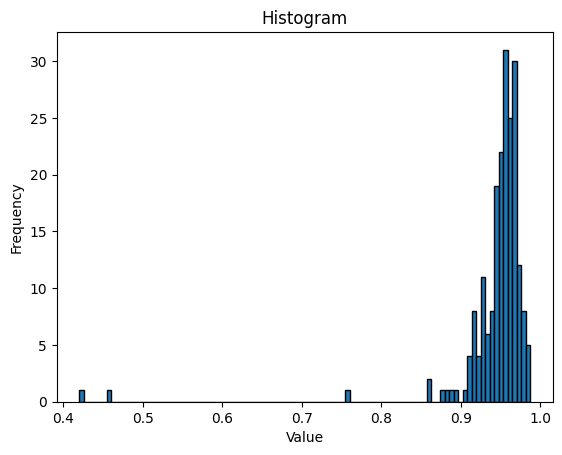

In [64]:
import matplotlib.pyplot as plt

# Build histogram
plt.hist(rnaseq_pairs_cors, bins=100, edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')

# Show the plot
plt.show()


In [65]:
import random

kremling2merged_d_n = {}

for key, value in rnaseq_pairs2correlate.items():
    if len(rnaseq_pairs2correlate[key]) == 2:
        random_number = random.randint(0, 1)
        fields = kremling_expression_key_dict[value[random_number]].split('.')
        #print(fields[2]+'_'+str(fields[1]))

        kremling2merged_d_n[value[random_number]] = fields[2]+'_'+str(fields[1])
        

In [66]:
# Rename the columns using the dictionary
kremling_expression_v5_renamed = kremling_expression_v5.rename(columns=kremling2merged_d_n)
kremling_expression_v5_renamed.columns = [str(x) for x in kremling_expression_v5_renamed.columns]

In [67]:
kremling_expression_v5_renamed.head()

,14A0253_26,10343264_LMAN26_CI21E_ATGAAC,10343927_LMAN8_B73_CACACT,14A0041_26,10343262_LMAN8_B109_TGCTAT,10343262_LMAN8_B14A_CTCTCG,10343262_LMAN8_B57_CCTAAG,14A0171_26,10343262_LMAN8_B79_GCAGCC,10343927_LMAN8_CI187-2_GACGAT,...,14A0047_8,10344823_LMAD8_IA2132_ACACGC,10343264_LMAD26_CML91_AACGCC,14A0453_26,10344827_LMAN26_Ki21_AAGACA,14A0367_26,10344826_LMAD8_E2558W_CGCAAC,14A0345_8,10344826_LMAD8_IDS69_CAGGAC,14A0343_8
Name,,,,,,,,,,,,,,,,,,,,,
Zm00001eb371370_T002,1.04145,0.0000,3.391060,0.0,0.0000,1.82712,0.284514,2.23201,0.437147,0.468934,...,0.00000,1.51042,0.00000,0.0,0.00000,2.82055,3.96967,0.00000,2.96105,0.00000
Zm00001eb371350_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371330_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371310_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371280_T001,1.27650,2.1092,0.692731,0.0,4.2798,1.47496,2.557320,0.00000,1.065940,1.149530,...,3.02253,0.41140,1.17447,0.0,3.48749,9.47506,6.19189,3.80776,1.03695,1.14981


In [68]:
kremling_expression_v5_renamed = kremling_expression_v5_renamed.filter(items=otu_table_merged_d_n.columns)
otu_table_merged_d_n = otu_table_merged_d_n.filter(items=kremling_expression_v5_renamed.columns)

In [69]:
kremling_expression_v5_renamed.head()

,14A0247_8,14A0051_8,14A0533_26,14A0295_8,14A0169_26,14A0069_8,14A0497_26,14A0023_8,14A0547_26,14A0572_26,...,14A0345_8,14A0267_8,14A0009_8,14A0007_8,14A0093_26,14A0137_26,14A0265_8,14A0155_26,14A0167_26,14A0481_26
Name,,,,,,,,,,,,,,,,,,,,,
Zm00001eb371370_T002,0.543707,0.853088,0.893650,0.000000,0.0,0.00000,0.926934,0.328449,0.667213,1.26085,...,0.00000,1.31987,5.56033,2.34082,0.0,0.00000,0.393696,1.72605,1.74131,1.03310
Zm00001eb371350_T001,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.000000,0.00000,0.00000,0.00000
Zm00001eb371330_T001,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.000000,0.00000,0.00000,0.00000
Zm00001eb371310_T001,0.000000,0.000000,0.406263,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.000000,0.00000,0.00000,0.00000
Zm00001eb371280_T001,1.332830,1.394160,0.365113,0.324968,0.0,2.68579,1.136120,2.939840,1.090390,5.15137,...,3.80776,7.54952,6.98986,2.67784,0.0,1.38371,0.321696,0.00000,2.13431,3.58775


In [70]:
otu_table_merged_d_n.head()

,14A0247_8,14A0051_8,14A0533_26,14A0295_8,14A0169_26,14A0069_8,14A0497_26,14A0023_8,14A0547_26,14A0572_26,...,14A0345_8,14A0267_8,14A0009_8,14A0007_8,14A0093_26,14A0137_26,14A0265_8,14A0155_26,14A0167_26,14A0481_26
OTU ID,,,,,,,,,,,,,,,,,,,,,
4479944,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
995900,0.0,0.0,0.0,8.0,6.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1124709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
541139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
533625,0.0,1.0,0.0,0.0,0.0,0.0,40.0,1.0,6.0,10.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0


In [71]:
if kremling_expression_v5_renamed.columns.all() == kremling_expression_v5_renamed.columns.all():
    print('Columns are equal!')

Columns are equal!


In [72]:
def count_zeros(df, threshold=0.5):
    # Count the number of zeros in each row
    # If the number of zeros is greater than the threshold, remove the row
    threshold_int = int(df.shape[1] * threshold)
    print(f'Threshold: {threshold_int} (threshold * number of columns)')
    zero_counts = df.apply(lambda row: (row == 0).sum(), axis=1)
    return df[zero_counts < threshold_int]

In [73]:
otu_table_merged_d_n_zeros_filtered = count_zeros(otu_table_merged_d_n)
kremling_expression_v5_renamed_zeros_filtered = count_zeros(kremling_expression_v5_renamed)

Threshold: 86 (threshold * number of columns)
Threshold: 86 (threshold * number of columns)


In [74]:
concatenated_df = pd.concat([kremling_expression_v5_renamed_zeros_filtered,
                             otu_table_merged_d_n_zeros_filtered], axis=0)

In [75]:
print(concatenated_df.shape)
print(kremling_expression_v5_renamed_zeros_filtered.shape)
print(otu_table_merged_d_n_zeros_filtered.shape)

(20965, 173)
(19848, 173)
(1117, 173)


In [76]:
concatenated_transposed = concatenated_df.T

In [77]:
from corals.threads import set_threads_for_external_libraries
set_threads_for_external_libraries(n_threads=1)
import numpy as np
from corals.correlation.full.default import cor_full

/home/rsantos/Repositories/maize_microbiome_transcriptomics/.venv/lib/python3.10/site-packages/corals/threads.py:48: UserWarning: This function should be called before `numpy` or similar modules are imported.
  warnings.warn("This function should be called before `numpy` or similar modules are imported.")


In [78]:
cor_values = cor_full(concatenated_transposed)
cor_values.shape

(20965, 20965)

In [79]:
highly_correlated_pairs_df = pd.DataFrame(columns=['feature1', 'feature2', 'correlation'])
correlated_pairs_file = open('correlated_pairs_merged_otus_transcripts.txt', 'w')

# Find the highly correlated pairs
for i in range(len(cor_values.columns)):
    for j in range(i+1, len(cor_values.columns)):
        if cor_values.columns[i] == cor_values.columns[j] or\
            (str(cor_values.columns[j]).startswith('Zm') and str(cor_values.columns[i]).startswith('Zm')):
            continue
        if ((abs(cor_values.iloc[i, j]) > 0.6) or\
           (abs(cor_values.iloc[i, j]) < -0.6)) and\
            (str(cor_values.columns[j]).startswith('Zm') or str(cor_values.columns[i]).startswith('Zm')):
            pair = (cor_values.columns[i], cor_values.columns[j])
            highly_correlated_pairs_df.loc[len(highly_correlated_pairs_df.index)] = [cor_values.columns[i],
                                                                                     cor_values.columns[j],
                                                                                     cor_values.iloc[i, j]]
            correlated_pairs_file.write(f'{cor_values.columns[i]}\t{cor_values.columns[j]}\t{cor_values.iloc[i, j]}\n')

correlated_pairs_file.close()